### **Importing Libraries**

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from datasets import load_dataset
import math
import gc
import psutil
from tqdm import tqdm
import time
import copy
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2024-11-17 00:10:09.743738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


[nltk_data] Downloading package punkt to /home/chetan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Printing few Info**

In [ ]:
model_name = "gpt2"

model_org = AutoModelForCausalLM.from_pretrained(
    "gpt2"
)

memory_footprint_bytes = model_org.get_memory_footprint()

memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)

print(f"Memory footprint: {memory_footprint_mb:.2f} MB")

# save_directory = "./Part_1_Models/gpt2"
# model_org.save_pretrained(save_directory)

Memory footprint: 486.70 MB


### **Quantized Model Impementation-1**

In [3]:
# def quantize_int8(tensor):
#     """
#     Quantize tensor to INT8 with proper scaling
#     """
#     tensor = tensor.to(torch.float32)
    
#     qmin = tensor.min()
#     qmax = tensor.max()
    
#     scale = (qmax - qmin) / 255.0  # 255 = 2^8 - 1
#     zero_point = (-128 - qmin / scale).round().clamp(-128, 127).to(torch.int8)
    
#     quant_tensor = (tensor / scale + zero_point).round().clamp(-128, 127).to(torch.int8)
    
#     return quant_tensor, scale, zero_point

# def dequantize_int8(quant_tensor, scale, zero_point):
#     """
#     Dequantize INT8 tensor back to floating point
#     """
#     return scale * (quant_tensor.to(torch.float32) - zero_point)

# class Int8LinearLayer(nn.Module):
#     def __init__(self, input_features, output_features, bias=True, dtype=torch.float32):
#         super().__init__()
        
#         self.register_buffer("quant_weights", 
#                            torch.zeros((output_features, input_features), dtype=torch.int8))
#         self.register_buffer("scales", 
#                            torch.ones(output_features, dtype=torch.float32))
#         self.register_buffer("zero_points",
#                            torch.zeros(output_features, dtype=torch.int8))
        
#         if bias:
#             self.register_buffer("bias", 
#                                torch.zeros(output_features, dtype=dtype))
#         else:
#             self.bias = None
            
#     def forward(self, inputs):
#         """
#         Forward pass with INT8 quantized weights
#         """
#         inputs = inputs.to(torch.float16)
        
#         dequantized_weights = (
#             (self.quant_weights.float() - self.zero_points.unsqueeze(1)) * 
#             self.scales.unsqueeze(1)
#         ).to(inputs.dtype)
        
#         output = F.linear(inputs, dequantized_weights)
        
#         if self.bias is not None:
#             output = output + self.bias.to(inputs.dtype)
            
#         return output
    
#     def quantize(self, weights):
#         """
#         Quantize weights to INT8 with proper scaling
#         """
#         w_fp32 = weights.detach().clone().to(torch.float32)
        
#         for idx in range(w_fp32.size(0)):
#             row = w_fp32[idx]
#             quant_row, scale, zero_point = quantize_int8(row)
            
#             self.quant_weights[idx] = quant_row
#             self.scales[idx] = scale
#             self.zero_points[idx] = zero_point

# class Int8QuantModel(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.exclude_layers = ['wte', 'wpe']
        
#         self._replace_linear_layers()
    
#     def _replace_linear_layers(self):
#         """
#         Replace standard linear layers with INT8 quantized layers
#         """
#         for name, module in self.model.named_modules():
#             if isinstance(module, nn.Linear) and not any(exclude in name for exclude in self.exclude_layers):
#                 parent = self._get_parent_module(name)
#                 if parent is not None:
#                     layer_name = name.split('.')[-1]
#                     new_layer = Int8LinearLayer(
#                         module.in_features,
#                         module.out_features,
#                         bias=module.bias is not None,
#                         dtype=module.weight.dtype
#                     )
#                     new_layer.quantize(module.weight)
#                     if module.bias is not None:
#                         new_layer.bias = module.bias
                    
#                     setattr(parent, layer_name, new_layer)
    
#     def _get_parent_module(self, name):
#         """
#         Get parent module for a given module name
#         """
#         parent_path = '.'.join(name.split('.')[:-1])
#         if not parent_path:
#             return self.model
            
#         try:
#             parent = self.model
#             for part in parent_path.split('.'):
#                 parent = getattr(parent, part)
#             return parent
#         except AttributeError:
#             return None

#     def forward(self, input_ids=None, attention_mask=None, **kwargs):
#         if input_ids is not None:
#             input_ids = input_ids.long()
#         if attention_mask is not None:
#             attention_mask = attention_mask.to(torch.float16)
            
#         return self.model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             **kwargs
#         )
    
#     def get_memory_footprint(self):
#         """
#         Calculate total memory footprint of the quantized model using numel().
#         Returns total memory usage in bytes.
#         """
#         total_bytes = 0
        
#         # For each named parameter in the model
#         for name, param in self.model.named_parameters():
#             total_bytes += param.numel()*param.element_size()
                
#         return total_bytes

# model_name = "gpt2"

# model = AutoModelForCausalLM.from_pretrained(
#     "gpt2"
# )
# # Quantize all linear layers in the GPT-2 model
# model_quant=Int8QuantModel(model)
# print(model_quant)

# memory_footprint_bytes = model_quant.get_memory_footprint()

# memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)
# memory_footprint_gb = memory_footprint_bytes / (1024 ** 3)

# print(f"Memory footprint: {memory_footprint_bytes} bytes")
# print(f"Memory footprint: {memory_footprint_mb:.2f} MB")
# print(f"Memory footprint: {memory_footprint_gb:.2f} GB")


### **Quantized Model Implementation-2**

In [15]:
def quantize_int8(tensor):
    """
    Quantize tensor to INT8 with proper scaling
    """
    tensor = tensor.to(torch.float32)
    
    qmin = tensor.min()
    qmax = tensor.max()
    
    scale = (qmax - qmin) / 255.0  # 255 = 2^8 - 1
    zero_point = (-128 - qmin / scale).round().clamp(-128, 127).to(torch.int8)
    
    quant_tensor = (tensor / scale + zero_point).round().clamp(-128, 127).to(torch.int8)
    
    return quant_tensor, scale, zero_point

def dequantize_int8(quant_tensor, scale, zero_point):
    """
    Dequantize INT8 tensor back to floating point
    """
    return scale * (quant_tensor.to(torch.float32) - zero_point)

class WholeQuantizationModel(torch.nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.quantization_params = {}
        self.model_size = 0
        
        self.device = next(original_model.parameters()).device
        self.original_model = original_model.to(self.device)
        
        with torch.no_grad():
            for name, param in self.original_model.named_parameters():
                param.data = param.data.to(self.device) 
                quantized_tensor, scale, zero_point = quantize_int8(param.data)
                self.model_size += quantized_tensor.numel()
                
                self.quantization_params[name] = {
                    "quantized": quantized_tensor.to(self.device),
                    "scale": scale,
                    "zero_point": zero_point,
                }
                
                dequantized = dequantize_int8(
                    quantized_tensor, 
                    scale, 
                    zero_point
                ).to(self.device)
                
                param.data.copy_(dequantized)
        
        self.model_size = self.model_size / (1024 ** 2)
    
    def to(self, device):
        self.device = device
        self.original_model = self.original_model.to(device)
        return super().to(device)
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        input_ids = input_ids.to(self.device)
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        if labels is not None:
            labels = labels.to(self.device)
            
        with torch.no_grad():
            outputs = self.original_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                **kwargs
            )
        return outputs
    
    def generate(self, input_ids, attention_mask=None, **kwargs):
        """Add generate functionality"""
        # Ensure to handle quantization correctly during generation
        return self.original_model.generate(input_ids, attention_mask=attention_mask, **kwargs)

model = AutoModelForCausalLM.from_pretrained(
    "gpt2"
)
quantFullModel = WholeQuantizationModel(model)
print(f"8-bit Quantized Model Size: {quantFullModel.model_size:.2f} MB")

torch.save(quantFullModel.state_dict(), './Part_1_Models/quantized_whole.pth')

8-bit Quantized Model Size: 118.68 MB


### **Partial Quantization Model**

In [16]:
class Decoder_QuantizedModel(torch.nn.Module):
    def __init__(self, original_model, quantized_blocks):
        super().__init__()
        self.quantization_params = {}
        self.model_size = 0
        self.quantized_blocks = quantized_blocks
        
        self.device = next(original_model.parameters()).device
        
        self.original_model = original_model.to(self.device)
        
        with torch.no_grad():
            for name, param in self.original_model.named_parameters():
                param.data = param.data.to(self.device) 
                is_decoder_block = any(f"transformer.h.{idx}." in name for idx in self.quantized_blocks)
                if is_decoder_block:
                    quantized_tensor, scale, zero_point = quantize_int8(param.data)
                    self.model_size += quantized_tensor.numel()
                    
                    self.quantization_params[name] = {
                        "quantized": quantized_tensor.to(self.device),
                        "scale": scale,
                        "zero_point": zero_point,
                    }
                    
                    dequantized = dequantize_int8(
                        quantized_tensor, 
                        scale, 
                        zero_point
                    ).to(self.device)
                    
                    param.data.copy_(dequantized)
                else:
                    self.model_size += param.numel() * param.element_size()
        
        self.model_size = self.model_size / (1024 ** 2)
    
    def to(self, device):
        """Override to method to handle device movement"""
        self.device = device
        self.original_model = self.original_model.to(device)
        return super().to(device)
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        input_ids = input_ids.to(self.device)
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        if labels is not None:
            labels = labels.to(self.device)
            
        with torch.no_grad():
            outputs = self.original_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                **kwargs
            )
        return outputs

    def generate(self, input_ids, attention_mask=None, **kwargs):
        """Add generate functionality"""
        # Ensure to handle quantization correctly during generation
        return self.original_model.generate(input_ids, attention_mask=attention_mask, **kwargs)

model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)

num_layers = len(model.transformer.h)
quantized_blocks = list(range(1, num_layers-1))
quantSelModel = Decoder_QuantizedModel(model, quantized_blocks)
print(f"8-bit Selected Quantized Model Size: {quantSelModel.model_size:.2f} MB")

torch.save(quantSelModel.state_dict(), './Part_1_Models/quantized_select.pth')

8-bit Selected Quantized Model Size: 271.91 MB


### **Corpus Retrieval**

In [6]:
def retrieve_corpus(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        corpus = []
        for line in file:
            # print(line.strip().lower())
            corpus.append(line.lower())
        return corpus
    
def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word not in string.punctuation]
    
# corpus_train = retrieve_corpus("./Dataset/ptb.train.txt")
# corpus_test = retrieve_corpus("./Dataset/ptb.test.txt")
# corpus_val = retrieve_corpus("./Dataset/ptb.valid.txt")

### **Dataset Loading**

In [7]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

eval_texts = []
for item in dataset:
    if item['text'].strip():
        eval_texts.append(item['text'])
        if len(eval_texts) >= 3000:
            break
print(f"Loaded {len(eval_texts)} samples for evaluation")
test_data = eval_texts

Loaded 2891 samples for evaluation


### **Testing**

In [8]:
def compute_perplexity(model, tokenizer, dataset, max_length=1024, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for example in tqdm(dataset, desc="Calculating perplexity"):
            encodings = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            
            labels = input_ids.clone()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_loss += loss.item()
            total_tokens += attention_mask.sum().item() - 1

        perplexity = math.exp(total_loss / total_tokens)

    return perplexity

def infer_text(model, tokenizer, prompt_text, max_length=50, device='cpu'):

    input_ids = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    generated_sequence = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=30,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=input_ids.new_ones(input_ids.shape)
    )
    return tokenizer.decode(generated_sequence[0], skip_special_tokens=True)

def measure_inference_time(model, tokenizer, prompt_text, device='cpu'):
    start = time.time()
    with torch.no_grad():
        infer_text(model, tokenizer, prompt_text, device=device)
    return time.time() - start

def evaluate_model(model,model_name="gpt2", dataset=None, device='cpu'):

    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model.to(device) 

    perplexity_before = compute_perplexity(model, tokenizer, dataset, device=device)

    latency_before = measure_inference_time(model, tokenizer, dataset[0], device=device)
    
    
    return {
        "Latency": latency_before,
        "Perplexity": perplexity_before,
    }

### **Results**

In [9]:
results = evaluate_model(model_org, model_name="gpt2", dataset=test_data, device=device)
print("Original Model")
print(results)

results = evaluate_model(quantFullModel, model_name="gpt2", dataset=test_data, device=device)
print("8 Bit  Whole Quantized Model")
print(results)

results = evaluate_model(quantSelModel, model_name="gpt2", dataset=test_data, device=device)
print("8 Bit  Selective Quantized Model")
print(results)

Calculating perplexity: 100%|██████████| 2891/2891 [00:40<00:00, 72.18it/s] 


Original Model
{'Latency': 0.3262801170349121, 'Perplexity': 49.615657664681976}


Calculating perplexity: 100%|██████████| 2891/2891 [00:40<00:00, 71.72it/s] 


8 Bit  Whole Quantized Model
{'Latency': 0.18835139274597168, 'Perplexity': 51.60515713002346}


Calculating perplexity: 100%|██████████| 2891/2891 [00:40<00:00, 71.35it/s] 


8 Bit  Selective Quantized Model
{'Latency': 0.1855759620666504, 'Perplexity': 51.08351577253234}


### **Plotting**

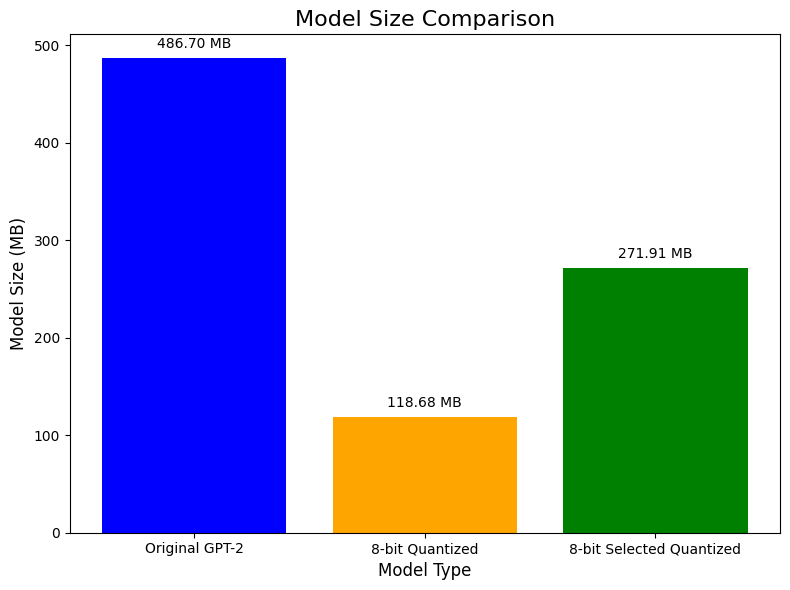

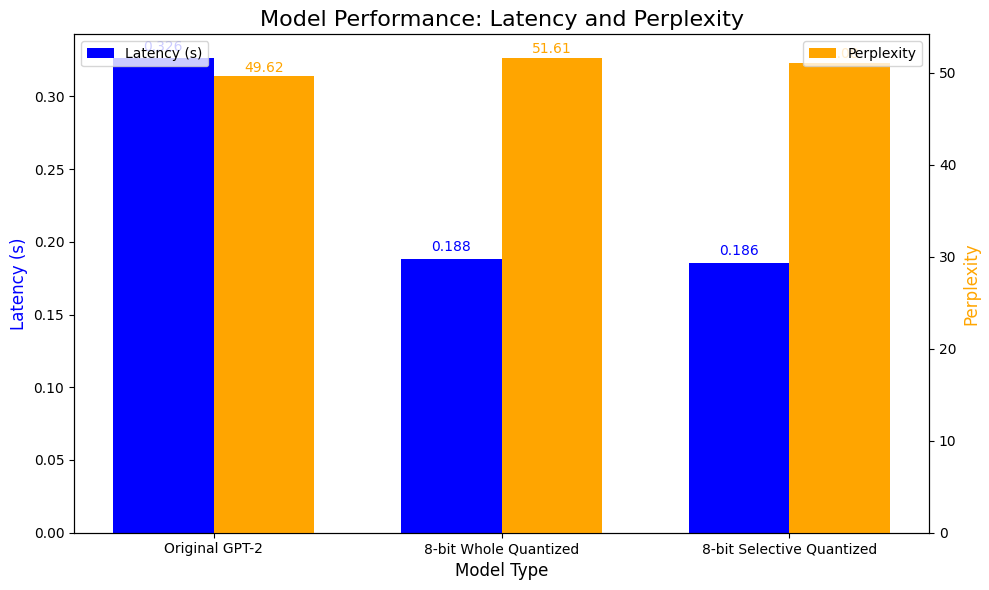

In [ ]:
model_types = ["Original GPT-2", "8-bit Quantized", "8-bit Selected Quantized"]
model_sizes = [486.70, 118.68, 271.91]

plt.figure(figsize=(8, 6))
plt.bar(model_types, model_sizes, color=["blue", "orange", "green"])

plt.title("Model Size Comparison", fontsize=16)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("Model Size (MB)", fontsize=12)

for i, size in enumerate(model_sizes):
    plt.text(i, size + 10, f"{size:.2f} MB", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('memory_part1.png')

models = ["Original GPT-2", "8-bit Whole Quantized", "8-bit Selective Quantized"]
latencies = [0.3262801170349121, 0.18835139274597168, 0.1855759620666504]
perplexities = [49.615657664681976, 51.60515713002346, 51.08351577253234]

fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = np.arange(len(models))
ax1.bar(x - bar_width/2, latencies, bar_width, label='Latency (s)', color='blue')

ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, perplexities, bar_width, label='Perplexity', color='orange')

ax1.set_xlabel('Model Type', fontsize=12)
ax1.set_ylabel('Latency (s)', fontsize=12, color='blue')
ax2.set_ylabel('Perplexity', fontsize=12, color='orange')
ax1.set_title('Model Performance: Latency and Perplexity', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(models)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

for i, (lat, perp) in enumerate(zip(latencies, perplexities)):
    ax1.text(i - bar_width/2, lat + 0.005, f"{lat:.3f}", ha='center', fontsize=10, color='blue')
    ax2.text(i + bar_width/2, perp + 0.5, f"{perp:.2f}", ha='center', fontsize=10, color='orange')

plt.tight_layout()
plt.savefig('inference_part1.png')
